In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import pickle
import wordcloud
import re
import tensorflow as tf
from dateutil.parser import parse
import matplotlib
from nltk.corpus import stopwords
import sklearn
from textblob import TextBlob
import itertools
import sklearn
from sklearn.metrics import confusion_matrix
import nltk
nltk.download('stopwords')
nltk.download('punkt')

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

# **Research Question -1**

Overall Rating vs review sentiments across Amazon and Goodreads. (Rating info of reviewers vs non-reviewers)

In [ ]:
book_info_df = pd.read_pickle("/content/drive/My Drive/book_reviews/book_info_with_authors_df_common.pkl")
book_reviews_df = pd.read_pickle("/content/drive/My Drive/book_reviews/goodreads_reviews_df_common.pkl")

amazon_book_df = pd.read_pickle("/content/drive/My Drive/amazon_reviews/amazon_books_df_common.pkl")
amazon_reviews_df = pd.read_pickle("/content/drive/My Drive/amazon_reviews/amazon_reviews_df_common.pkl")

In [ ]:
amazon_reviews_df.loc[(amazon_reviews_df.reviewText.isna()), "reviewText"] = ""

In [ ]:
## https://medium.com/@b.terryjack/nlp-pre-trained-sentiment-analysis-1eb52a9d742c

book_reviews_df["polarity"] = book_reviews_df.review_text.apply(lambda x: TextBlob(x).sentiment.polarity)
amazon_reviews_df["polarity"] = amazon_reviews_df.reviewText.apply(lambda x: TextBlob(x).sentiment.polarity)

#### **Min-max normalization of polarity and ratings between 0 and 1**
Because, polarity has a range between -1 and 1. And the rating has a range between 0 and 5. Hence, in order to compare both of them, we need normalization of the ratings with the common scale (0-1).

In [ ]:
def normalize_rating(x):
  min, max = 0, 5
  return (x-min)/(max-min)

book_reviews_df["rating_norm"] = book_reviews_df.rating.apply(lambda x: normalize_rating(x))
amazon_reviews_df["rating_norm"] = amazon_reviews_df.overall.apply(lambda x: normalize_rating(x))

In [ ]:
def normalize_polarity(x):
  min, max = -1, 1
  return (x-min)/(max-min)

book_reviews_df["polarity_norm"] = book_reviews_df.polarity.apply(lambda x: normalize_polarity(x))
amazon_reviews_df["polarity_norm"] = amazon_reviews_df.polarity.apply(lambda x: normalize_polarity(x))

## **Grouped based on Book id**

In [ ]:
aggregated_goodreads_ratings = book_reviews_df.groupby("book_id").mean()[["rating_norm", "polarity_norm"]].reset_index()
aggregated_goodreads_ratings["delta"] = aggregated_goodreads_ratings.rating_norm - aggregated_goodreads_ratings.polarity_norm

aggregated_amazon_ratings = amazon_reviews_df.groupby("asin").mean()[["rating_norm", "polarity_norm"]].reset_index()
aggregated_amazon_ratings["delta"] = aggregated_amazon_ratings.rating_norm - aggregated_amazon_ratings.polarity_norm

### **Histogram plot of the delta values(difference between rating and polarity)**

Both of them shows a skewed distribution. The reviews relatively consists of negative polarity compared to its ratings. Hence, users end up giving good ratings, however the reviews tells us exactly whether the book is good or bad.

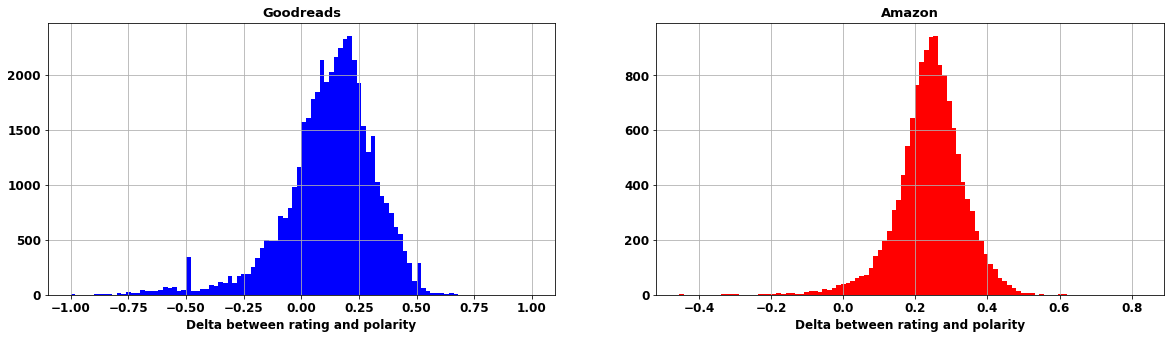

In [ ]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.hist(aggregated_goodreads_ratings.delta, bins=100, color="blue")
plt.title("Goodreads", fontweight="bold", fontsize=13)
plt.xlabel("Delta between rating and polarity", fontweight="bold", fontsize=12)
plt.xticks(fontsize=12, fontweight="bold")
plt.yticks(fontsize=12, fontweight="bold")
plt.grid()

plt.subplot(1, 2, 2)
plt.hist(aggregated_amazon_ratings.delta, bins=100, color="red")
plt.title("Amazon", fontweight="bold", fontsize=13)
plt.xlabel("Delta between rating and polarity", fontweight="bold", fontsize=12)
plt.xticks(fontsize=12, fontweight="bold")
plt.yticks(fontsize=12, fontweight="bold")
plt.grid()

plt.show()

## **Grouped based on User id**

In [ ]:
aggregated_goodreads_ratings_users = book_reviews_df.groupby("user_id").mean()[["rating_norm", "polarity_norm"]].reset_index()
aggregated_goodreads_ratings_users["delta"] = aggregated_goodreads_ratings_users.rating_norm - aggregated_goodreads_ratings_users.polarity_norm

aggregated_amazon_ratings_users = amazon_reviews_df.groupby("reviewerID").mean()[["rating_norm", "polarity_norm"]].reset_index()
aggregated_amazon_ratings_users["delta"] = aggregated_amazon_ratings_users.rating_norm - aggregated_amazon_ratings_users.polarity_norm

### **Histogram plot of the delta values(difference between rating and polarity)**

Both of them shows a skewed distribution. The reviews relatively consists of negative polarity compared to its ratings. Hence, users end up giving good ratings, however the reviews tells us exactly whether the book is good or bad.

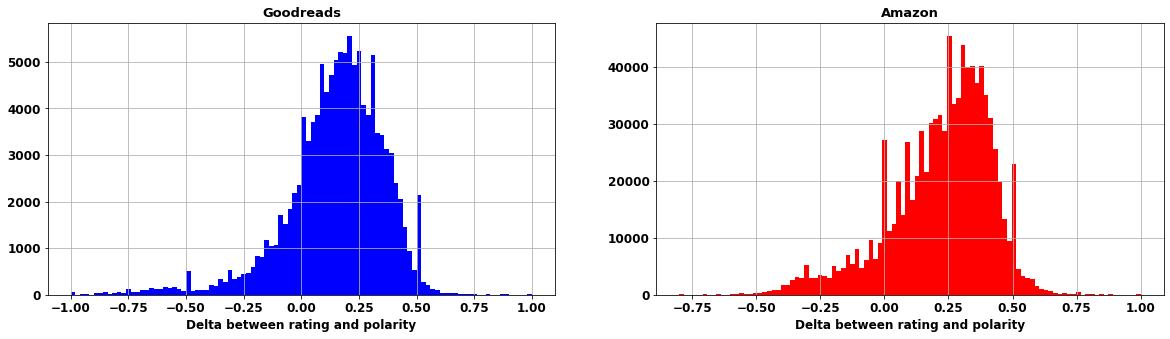

In [ ]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.hist(aggregated_goodreads_ratings_users.delta, bins=100, color="blue")
plt.title("Goodreads", fontweight="bold", fontsize=13)
plt.xlabel("Delta between rating and polarity", fontweight="bold", fontsize=12)
plt.xticks(fontsize=12, fontweight="bold")
plt.yticks(fontsize=12, fontweight="bold")
plt.grid()

plt.subplot(1, 2, 2)
plt.hist(aggregated_amazon_ratings_users.delta, bins=100, color="red")
plt.title("Amazon", fontweight="bold", fontsize=13)
plt.xlabel("Delta between rating and polarity", fontweight="bold", fontsize=12)
plt.xticks(fontsize=12, fontweight="bold")
plt.yticks(fontsize=12, fontweight="bold")
plt.grid()

plt.show()

# **Research question - 2**
Can we predict from the sample review that whether it belongs to amazon or goodreads data?

In [ ]:
book_reviews_df = pd.read_pickle("/content/drive/My Drive/book_reviews/goodreads_reviews_df_common.pkl")
amazon_reviews_df = pd.read_pickle("/content/drive/My Drive/amazon_reviews/amazon_reviews_df_common.pkl")

In [ ]:
goodreads_df = pd.DataFrame()
goodreads_df["review_text"] = book_reviews_df.review_text
goodreads_df["label"] = "goodreads"
goodreads_df = goodreads_df[:449236]

amazon_df = pd.DataFrame()
amazon_df["review_text"] = amazon_reviews_df.reviewText
amazon_df["label"] = "amazon"
amazon_df = amazon_df[:449236]

In [ ]:
reviews_df = pd.concat([goodreads_df, amazon_df], ignore_index=True)
reviews_df = reviews_df.sample(frac=1)

In [ ]:
### https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17

def preprocess_texts(text):
  REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
  BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
  STOPWORDS = set(stopwords.words('english'))
  
  if text is None: 
    return ""
  text = text.lower() # lowercase text
  text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
  text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
  text = text.replace('x', '')
  text = ' '.join(word for word in text.split() if word not in STOPWORDS)

  return text

In [ ]:
reviews_df["review_text_processed"] = reviews_df.review_text.apply(lambda x: preprocess_texts(x))

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(reviews_df['review_text_processed'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 739495 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(reviews_df['review_text_processed'].values)
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)


Y = pd.get_dummies(reviews_df['label']).values
print('Shape of label tensor:', Y.shape)

Shape of data tensor: (898472, 250)
Shape of label tensor: (898472, 2)


In [ ]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(808624, 250) (808624, 2)
(89848, 250) (89848, 2)


In [ ]:
X.shape[1]

250

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(tf.keras.layers.SpatialDropout1D(0.2))
model.add(tf.keras.layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(tf.keras.layers.Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 15
batch_size = 1024

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Epoch 1/15
711/711 [==============================] - 2910s 4s/step - loss: 0.4511 - accuracy: 0.7852 - val_loss: 0.4028 - val_accuracy: 0.8146
Epoch 2/15
711/711 [==============================] - 2888s 4s/step - loss: 0.3710 - accuracy: 0.8309 - val_loss: 0.3810 - val_accuracy: 0.8263
Epoch 3/15
711/711 [==============================] - 2870s 4s/step - loss: 0.3416 - accuracy: 0.8451 - val_loss: 0.3782 - val_accuracy: 0.8286
Epoch 4/15
711/711 [==============================] - 2886s 4s/step - loss: 0.3205 - accuracy: 0.8552 - val_loss: 0.3779 - val_accuracy: 0.8288
Epoch 5/15
711/711 [==============================] - 2929s 4s/step - loss: 0.3053 - accuracy: 0.8624 - val_loss: 0.3842 - val_accuracy: 0.8275
Epoch 6/15
711/711 [==============================] - 2881s 4s/step - loss: 0.2919 - accuracy: 0.8686 - val_loss: 0.4001 - val_accuracy: 0.8277
Epoch 7/15
711/711 [==============================] - 2884s 4s/step - loss: 0.2798 - accuracy: 0.8748 - val_loss: 0.4221 - val_accuracy:

In [ ]:
results = model.evaluate(X_test,Y_test, batch_size=128)
print("test loss, test acc:", results)

702/702 [==============================] - 64s 91ms/step - loss: 0.5224 - accuracy: 0.8181
test loss, test acc: [0.5223966240882874, 0.8181039094924927]


In [ ]:
model.save('/content/drive/My Drive/saved_model.pkl')

INFO:tensorflow:Assets written to: /content/drive/My Drive/saved_model.pkl/assets


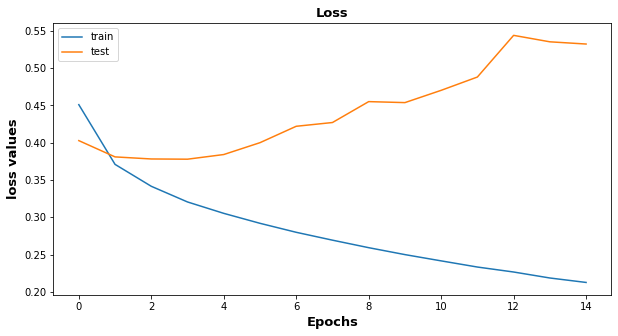

In [ ]:
plt.figure(figsize=(10, 5))
plt.title('Loss', fontweight="bold", fontsize=13)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylabel("loss values", fontweight="bold", fontsize=13)
plt.xlabel("Epochs", fontweight="bold", fontsize=13)
plt.legend()
plt.show()

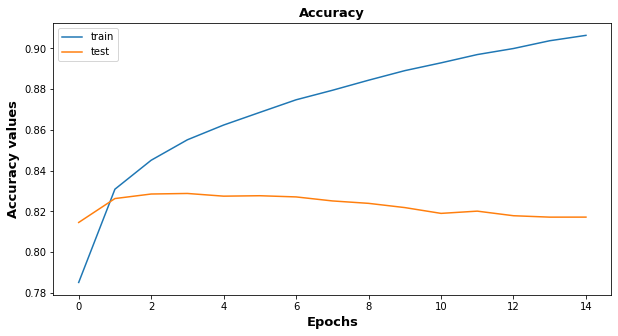

In [ ]:
plt.figure(figsize=(10, 5))
plt.title('Accuracy', fontweight="bold", fontsize=13)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.ylabel("Accuracy values", fontweight="bold", fontsize=13)
plt.xlabel("Epochs", fontweight="bold", fontsize=13)
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
labels_mapping = {0:"amazon", 1: "goodreads"}

In [ ]:
cm = confusion_matrix(pd.Series(Y_test.argmax(axis=1)).apply(lambda x: labels_mapping[x]).values, 
                      pd.Series(y_pred.argmax(axis=1)).apply(lambda x: labels_mapping[x]).values, labels=["amazon", "goodreads"])
cm = cm/cm.sum(axis=1)

In [ ]:
# https://www.tensorflow.org/tensorboard/image_summaries
def confusion_matrix_plot(conf_matrix, class_names):
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    labels = np.around(conf_matrix.astype('float'), decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = conf_matrix.max() / 2.
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        color = "white" if conf_matrix[i, j] > threshold else "black"
        plt.text(j, i, labels[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


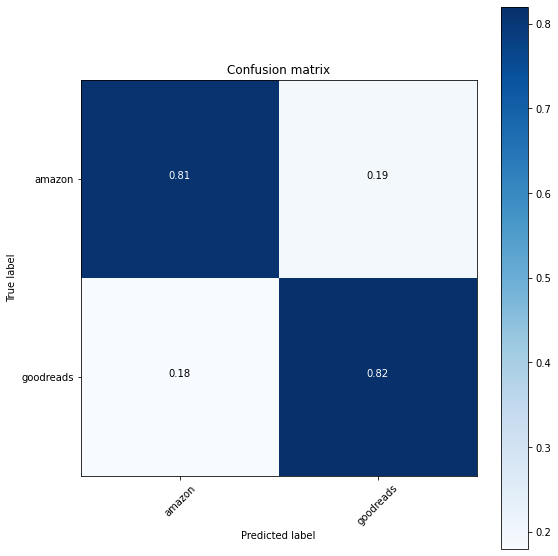

In [ ]:
confusion_matrix_plot(cm, ["amazon", "goodreads"])

## **visualize layers**

In [ ]:
## https://becominghuman.ai/visualizing-representations-bd9b62447e38

In [ ]:
###  Truncate X_test values to only first 50,000 samples among 89K samples due to Memory limitation

X_test_truncated = X_test[:50000]
Y_test_truncated = Y_test[:50000]

In [ ]:
def create_truncated_model(trained_model):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
    model.add(tf.keras.layers.SpatialDropout1D(0.2))
    model.add(tf.keras.layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    
    for i, layer in enumerate(model.layers):
        layer.set_weights(trained_model.layers[i].get_weights())
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

truncated_model = create_truncated_model(model2)
hidden_features = truncated_model.predict(X_test_truncated)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=20)
pca_result = pca.fit_transform(hidden_features)
print('Variance PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))

#Run T-SNE on the PCA features.
tsne = TSNE(n_components=2, verbose = 1)
tsne_results = tsne.fit_transform(pca_result)

Variance PCA: 0.9835735559463501
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 50000 samples in 0.159s...
[t-SNE] Computed neighbors for 50000 samples in 12.658s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 12000 / 50000
[t-SNE] Computed

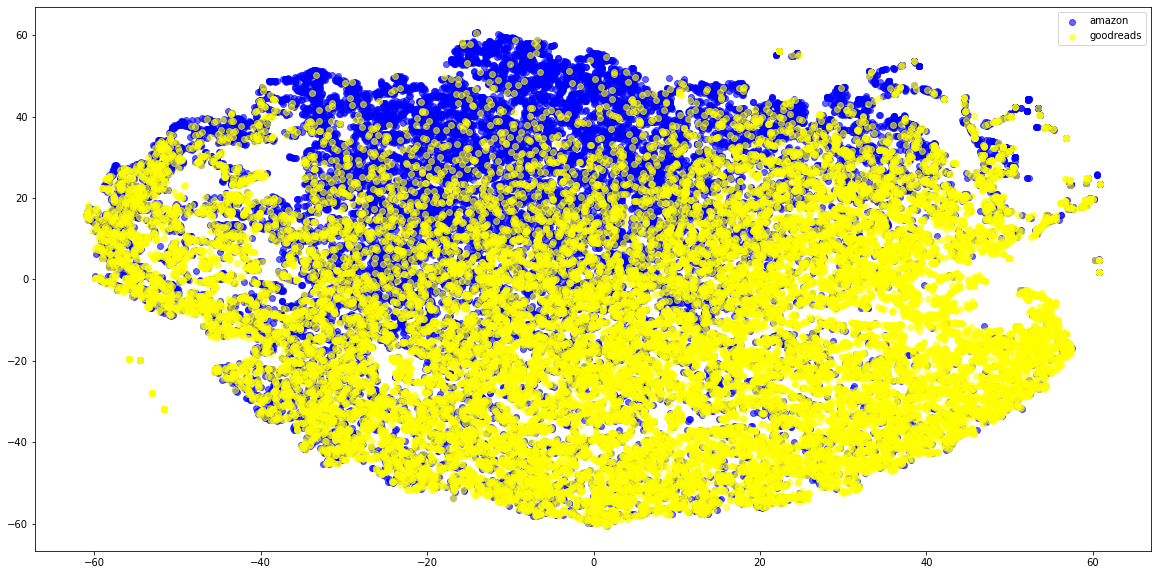

In [ ]:
from keras.utils import np_utils
%matplotlib inline

labels_mapping = {0: "amazon", 1: "goodreads"}
color_map = np.argmax(Y_test_truncated, axis=1)
colors = {0: "blue", 1: "yellow"}
plt.figure(figsize=(20,10))
for cl in range(2):
    indices = np.where(color_map==cl)
    indices = indices[0]
    plt.scatter(tsne_results[indices,0], tsne_results[indices, 1], label=labels_mapping[cl], color=colors[cl], alpha=0.6)
plt.legend()
plt.show()



## **Research question -3**

Does the consistency between amazon and goodreads reviewsand its sentiments change over time from the publication date?

In [ ]:
book_reviews_df["review_year"] = book_reviews_df.date_added.apply(lambda x: x[-4:])

In [ ]:
book_info_df.columns

Index(['goodreads_isbn', 'goodreads_text_reviews_count_x', 'goodreads_series',
       'goodreads_country_code', 'goodreads_language_code',
       'goodreads_popular_shelves', 'goodreads_asin', 'goodreads_is_ebook',
       'goodreads_average_rating_x', 'goodreads_kindle_asin',
       'goodreads_similar_books', 'goodreads_description', 'goodreads_format',
       'goodreads_link', 'goodreads_authors', 'goodreads_publisher',
       'goodreads_num_pages', 'goodreads_publication_day', 'goodreads_isbn13',
       'goodreads_publication_month', 'goodreads_edition_information',
       'goodreads_publication_year', 'goodreads_url', 'goodreads_image_url',
       'goodreads_book_id', 'goodreads_ratings_count_x', 'goodreads_work_id',
       'goodreads_title', 'goodreads_title_without_series',
       'goodreads_author_id', 'goodreads_average_rating_y',
       'goodreads_text_reviews_count_y', 'goodreads_author_name',
       'goodreads_ratings_count_y', 'goodreads_title_lower',
       'goodreads_autho

In [ ]:
amazon_reviews_df["review_datetime"] = pd.to_datetime(amazon_reviews_df.reviewTime)
amazon_reviews_df["review_year"] = amazon_reviews_df.review_datetime.dt.year.astype(str)

In [ ]:
amazon_reviews_df.columns

Index(['asin', 'image', 'overall', 'reviewText', 'reviewTime', 'reviewerID',
       'reviewerName', 'summary', 'unixReviewTime', 'verified', 'vote',
       'review_datetime', 'review_year'],
      dtype='object')

In [ ]:
goodreads_ratings_per_user = book_reviews_df.groupby(["review_year", "book_id"]).mean()[["rating"]].reset_index().rename(columns={"rating" : "goodreads_mean_ratings"})
amazon_ratings_per_user = amazon_reviews_df.groupby(["review_year", "asin"]).mean()[["overall"]].reset_index().rename(columns={"overall" : "amazon_mean_ratings"})

In [ ]:
goodreads_ratings_per_user = pd.merge(goodreads_ratings_per_user, book_info_df[["goodreads_book_id", "goodreads_title"]], left_on="book_id", right_on="goodreads_book_id", how="inner")
goodreads_ratings_per_user

,review_year,book_id,goodreads_mean_ratings,goodreads_book_id,goodreads_title
0,2001,228202,4.000000,228202,The Stand
1,2007,228202,4.454545,228202,The Stand
2,2008,228202,4.047619,228202,The Stand
3,2009,228202,3.750000,228202,The Stand
4,2010,228202,4.368421,228202,The Stand
...,...,...,...,...,...
100639,2017,9850553,3.000000,9850553,Soul Enchilada
100640,2017,9861631,3.000000,9861631,Avalon High
100641,2017,9870142,5.000000,9870142,The Mennyms
100642,2017,9937072,4.000000,9937072,The Stars My Destination


In [ ]:
amazon_ratings_per_user = pd.merge(amazon_ratings_per_user, amazon_book_df[["amazon_asin", "amazon_title"]], left_on="asin", right_on="amazon_asin", how="inner")
amazon_ratings_per_user

,review_year,asin,amazon_mean_ratings,amazon_asin,amazon_title
0,1997,0002243768,5.000000,0002243768,Furnace
1,1998,0002243768,4.000000,0002243768,Furnace
2,2000,0002243768,4.625000,0002243768,Furnace
3,2001,0002243768,3.500000,0002243768,Furnace
4,2002,0002243768,3.400000,0002243768,Furnace
...,...,...,...,...,...
64666,2018,1484758056,4.311111,1484758056,Unearthed
64667,2018,1492642312,3.984615,1492642312,As You Wish
64668,2018,1492654299,4.194444,1492654299,Busted
64669,2018,1503900347,4.605263,1503900347,The Dragon Queen


In [ ]:
goodreads_amazon_merged = pd.merge(goodreads_ratings_per_user, amazon_ratings_per_user, left_on=["goodreads_title", "review_year"], right_on=["amazon_title", "review_year"], how="inner")
goodreads_amazon_merged

,review_year,book_id,goodreads_mean_ratings,goodreads_book_id,goodreads_title,asin,amazon_mean_ratings,amazon_asin,amazon_title
0,2001,228202,4.000000,228202,The Stand,0307743683,4.700000,0307743683,The Stand
1,2007,228202,4.454545,228202,The Stand,0307743683,4.309524,0307743683,The Stand
2,2007,10945764,4.000000,10945764,The Stand,0307743683,4.309524,0307743683,The Stand
3,2007,1360681,4.000000,1360681,The Stand,0307743683,4.309524,0307743683,The Stand
4,2007,1454116,3.000000,1454116,The Stand,0307743683,4.309524,0307743683,The Stand
...,...,...,...,...,...,...,...,...,...
49487,2017,8484497,3.000000,8484497,The Dark Side,1501119567,3.400000,1501119567,The Dark Side
49488,2017,866181,3.000000,866181,The Dark Side,1501119567,3.400000,1501119567,The Dark Side
49489,2017,915541,5.000000,915541,The Witching Hour,0099471426,4.195402,0099471426,The Witching Hour
49490,2017,933965,2.000000,933965,The Looking Glass Wars,0142409413,4.666667,0142409413,The Looking Glass Wars


In [ ]:
goodreads_amazon_merged = goodreads_amazon_merged.groupby(["amazon_title", "review_year"]).mean()[["goodreads_mean_ratings", "amazon_mean_ratings"]].reset_index() #.rename(columns={"review_year":"count"}).sort_values(by="count", ascending=False)

In [ ]:
goodreads_amazon_merged.groupby("amazon_title").count()[["review_year"]].reset_index().sort_values(by="review_year", ascending=False)

,amazon_title,review_year
7001,The Stand,13
3283,Life of Pi,13
5650,The Dark Half,12
6151,The Hobbit,12
6527,The Moon is a Harsh Mistress,12
...,...,...
3860,No Reflection (The Furies) (Volume 1),1
3859,No Place Like Home,1
3856,No One Gets Out Alive: A Novel,1
3855,No Mercy,1


In [ ]:
## By taking mean and std across all the book titles for a given year

goodreads_aggregated = goodreads_amazon_merged.groupby("review_year").agg(['mean', 'std'])["goodreads_mean_ratings"].reset_index().rename(columns={"mean":"goodreads_yearly_mean", "std":"goodreads_yearly_std"})
amazon_aggregated = goodreads_amazon_merged.groupby("review_year").agg(['mean', 'std'])["amazon_mean_ratings"].reset_index().rename(columns={"mean":"amazon_yearly_mean", "std":"amazon_yearly_std"})
goodreads_amazon_aggregated = pd.merge(goodreads_aggregated, amazon_aggregated, how="inner", on="review_year")
goodreads_amazon_aggregated = goodreads_amazon_aggregated.loc[~goodreads_amazon_aggregated.goodreads_yearly_std.isna()]
goodreads_amazon_aggregated

,review_year,goodreads_yearly_mean,goodreads_yearly_std,amazon_yearly_mean,amazon_yearly_std
2,2005,4.428571,0.975900,4.154884,0.445577
3,2006,4.666667,0.577350,4.059519,0.246419
4,2007,3.542477,1.177900,4.132187,0.782083
5,2008,3.568918,0.974899,4.113282,0.841737
6,2009,3.385460,1.051192,4.084021,0.853912
7,2010,3.449940,0.999486,4.128979,0.786802
8,2011,3.583512,0.946625,4.134385,0.769124
9,2012,3.607224,0.959217,4.217928,0.651928
10,2013,3.656754,0.963851,4.294749,0.543267
11,2014,3.703585,0.937951,4.328207,0.494139


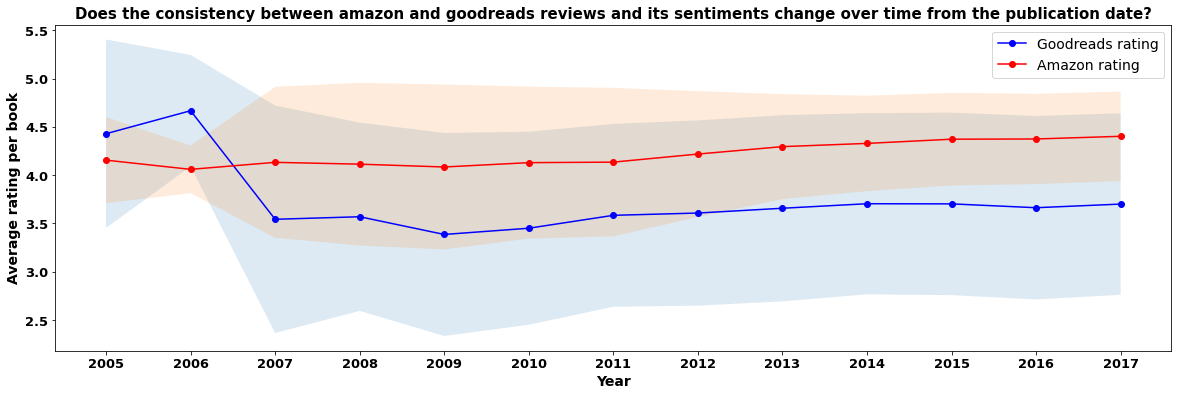

In [ ]:
plt.figure(figsize=(20, 6))

plt.plot(goodreads_amazon_aggregated.review_year, goodreads_amazon_aggregated.goodreads_yearly_mean, color="blue", marker='o', label="Goodreads rating")
#plt.errorbar(goodreads_amazon_aggregated.review_year, goodreads_amazon_aggregated.goodreads_yearly_mean, goodreads_amazon_aggregated.goodreads_yearly_std, linestyle='None', marker='^', fmt='o')
plt.fill_between(goodreads_amazon_aggregated.review_year, 
                 goodreads_amazon_aggregated.goodreads_yearly_mean - goodreads_amazon_aggregated.goodreads_yearly_std, 
                 goodreads_amazon_aggregated.goodreads_yearly_mean + goodreads_amazon_aggregated.goodreads_yearly_std, alpha=0.15)


plt.plot(goodreads_amazon_aggregated.review_year, goodreads_amazon_aggregated.amazon_yearly_mean, color="red", marker='o', label="Amazon rating")
#plt.errorbar(goodreads_amazon_aggregated.review_year, goodreads_amazon_aggregated.amazon_yearly_mean, goodreads_amazon_aggregated.amazon_yearly_std, linestyle='None', marker='^')
plt.fill_between(goodreads_amazon_aggregated.review_year, 
                 goodreads_amazon_aggregated.amazon_yearly_mean - goodreads_amazon_aggregated.amazon_yearly_std, 
                 goodreads_amazon_aggregated.amazon_yearly_mean + goodreads_amazon_aggregated.amazon_yearly_std, alpha=0.15)

plt.legend()
plt.xlabel("Year", fontweight="bold", fontsize=14)
plt.ylabel("Average rating per book", fontweight="bold", fontsize=14)
plt.xticks(fontsize=13, fontweight="bold")
plt.yticks(fontsize=13, fontweight="bold")
plt.legend(fontsize=14)
plt.title("Does the consistency between amazon and goodreads reviews and its sentiments change over time from the publication date?", fontweight="bold", fontsize=15)
#plt.grid()
plt.show()

# **Research question - 4**

##### Does the total review count affects the consistency in overall rating between Amazon and Goodreads?

In [ ]:
book_info_df = pd.read_pickle("/content/drive/My Drive/book_reviews/book_info_with_authors_df_common.pkl")
book_reviews_df = pd.read_pickle("/content/drive/My Drive/book_reviews/goodreads_reviews_df_common.pkl")

amazon_book_df = pd.read_pickle("/content/drive/My Drive/amazon_reviews/amazon_books_df_common.pkl")
amazon_reviews_df = pd.read_pickle("/content/drive/My Drive/amazon_reviews/amazon_reviews_df_common.pkl")

In [ ]:
book_df = pd.merge(book_info_df, book_reviews_df, left_on="goodreads_book_id", right_on="book_id", how="inner")

In [ ]:
num_reviews_per_book = book_reviews_df.groupby("book_id").count()[["review_id"]].reset_index().rename(columns={"review_id": "num_reviews"})
average_per_book = book_reviews_df.groupby("book_id").mean()[["rating"]].reset_index().rename(columns={"rating" : "average_ratings"})
average_per_book["average_ratings_rounded"] = np.round(average_per_book.average_ratings).astype(int)

avg_and_num_ratings_per_book = pd.merge(num_reviews_per_book, average_per_book, how="inner", on="book_id")

Text(0, 0.5, 'Number of reviews per book')

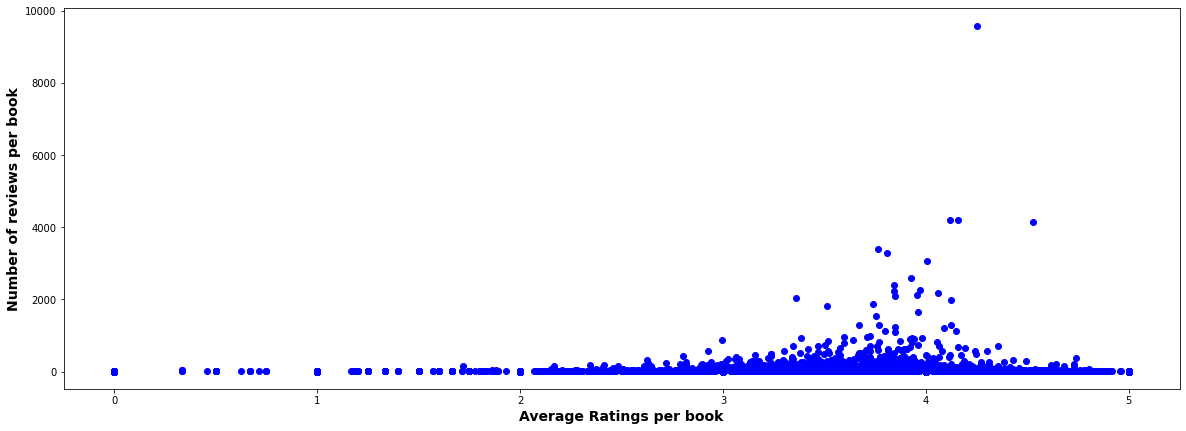

In [ ]:
plt.figure(figsize=(20, 7))
plt.scatter(avg_and_num_ratings_per_book['average_ratings'], avg_and_num_ratings_per_book.num_reviews.values, color="blue")
plt.xlabel("Average Ratings per book", fontweight="bold", fontsize=14)
plt.ylabel("Number of reviews per book", fontweight="bold", fontsize=14)

In [ ]:
amazon_df = pd.merge(amazon_book_df, amazon_reviews_df, how="inner", left_on="amazon_asin", right_on="asin")

In [ ]:
amazon_num_reviews_per_book = amazon_df.groupby("asin").count()[["reviewerID"]].reset_index().rename(columns={"reviewerID": "num_reviews"})
amazon_average_per_book = amazon_df.groupby("asin").mean()[["overall"]].reset_index().rename(columns={"overall": "avg_ratings"})

amazon_avg_and_num_ratings_per_book = pd.merge(amazon_num_reviews_per_book, amazon_average_per_book, how="inner", on="asin")

Text(0, 0.5, 'Number of reviews per book')

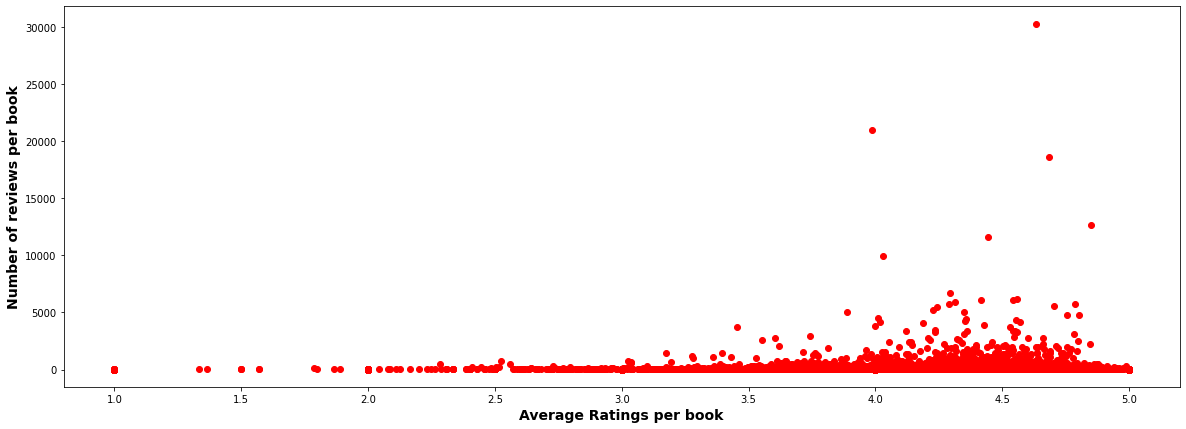

In [ ]:
plt.figure(figsize=(20, 7))
plt.scatter(amazon_avg_and_num_ratings_per_book['avg_ratings'], amazon_avg_and_num_ratings_per_book.num_reviews.values, color="red")
plt.xlabel("Average Ratings per book", fontweight="bold", fontsize=14)
plt.ylabel("Number of reviews per book", fontweight="bold", fontsize=14)

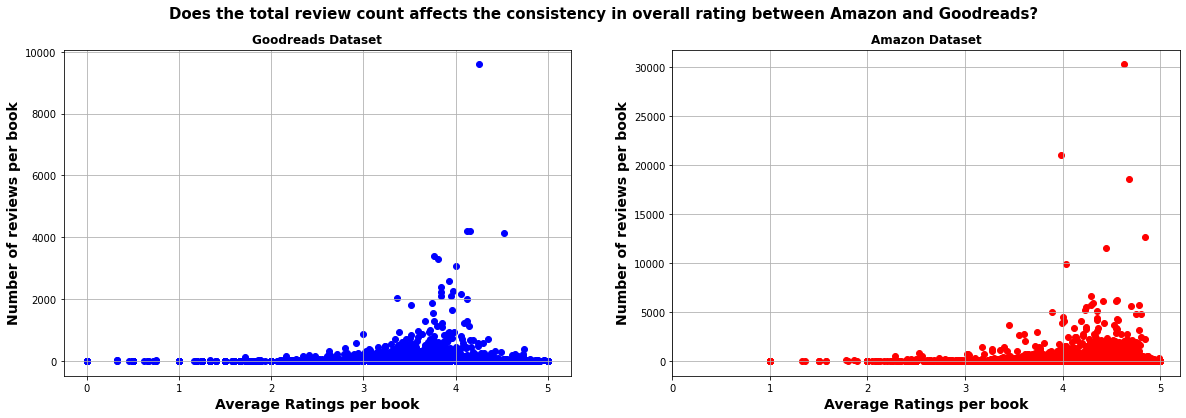

In [ ]:
## I also need to include distribution of the Number of reviews for amazon and goodreads dataset separately.

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.scatter(avg_and_num_ratings_per_book['average_ratings'], avg_and_num_ratings_per_book.num_reviews.values, color="blue")
plt.xlabel("Average Ratings per book", fontweight="bold", fontsize=14)
plt.ylabel("Number of reviews per book", fontweight="bold", fontsize=14)
plt.title("Goodreads Dataset", fontweight="bold")
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(amazon_avg_and_num_ratings_per_book['avg_ratings'], amazon_avg_and_num_ratings_per_book.num_reviews.values, color="red")
plt.xlabel("Average Ratings per book", fontweight="bold", fontsize=14)
plt.ylabel("Number of reviews per book", fontweight="bold", fontsize=14)
plt.title("Amazon Dataset", fontweight="bold")
plt.xticks(np.arange(0, 6))
plt.grid()

plt.suptitle("Does the total review count affects the consistency in overall rating between Amazon and Goodreads?", fontweight="bold", fontsize=15)
plt.show()

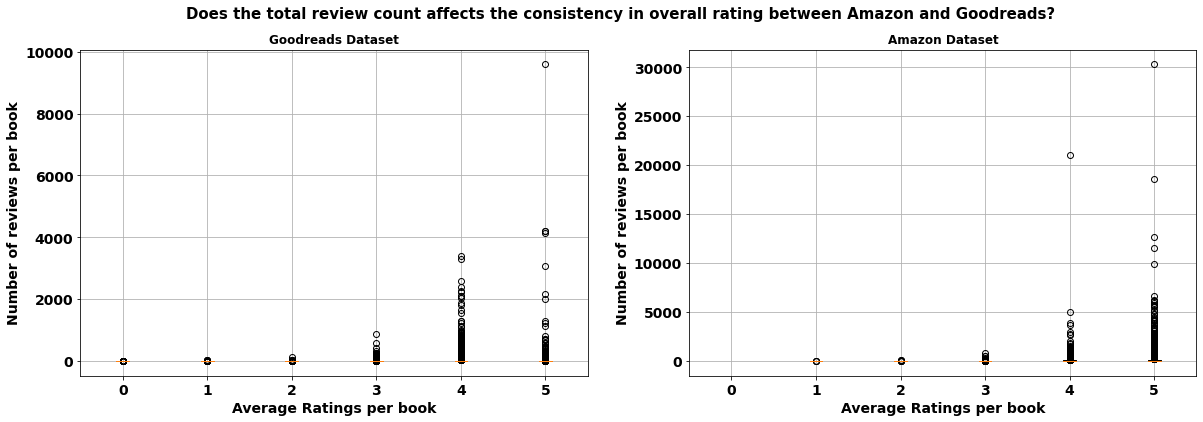

In [ ]:
## I also need to include distribution of the Number of reviews for amazon and goodreads dataset separately.

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.boxplot(avg_and_num_ratings_per_book.loc[avg_and_num_ratings_per_book.average_ratings==0].num_reviews.values, positions=[0])
plt.boxplot(avg_and_num_ratings_per_book.loc[(avg_and_num_ratings_per_book.average_ratings>0) & (avg_and_num_ratings_per_book.average_ratings<=1)].num_reviews.values, positions=[1])
plt.boxplot(avg_and_num_ratings_per_book.loc[(avg_and_num_ratings_per_book.average_ratings>1) & (avg_and_num_ratings_per_book.average_ratings<=2)].num_reviews.values, positions=[2])
plt.boxplot(avg_and_num_ratings_per_book.loc[(avg_and_num_ratings_per_book.average_ratings>2) & (avg_and_num_ratings_per_book.average_ratings<=3)].num_reviews.values, positions=[3])
plt.boxplot(avg_and_num_ratings_per_book.loc[(avg_and_num_ratings_per_book.average_ratings>3) & (avg_and_num_ratings_per_book.average_ratings<=4)].num_reviews.values, positions=[4])
plt.boxplot(avg_and_num_ratings_per_book.loc[(avg_and_num_ratings_per_book.average_ratings>4) & (avg_and_num_ratings_per_book.average_ratings<=5)].num_reviews.values, positions=[5])

plt.xticks(fontweight="bold", fontsize=14)
plt.yticks(fontweight="bold", fontsize=14)
plt.xlabel("Average Ratings per book", fontweight="bold", fontsize=14)
plt.ylabel("Number of reviews per book", fontweight="bold", fontsize=14)
plt.title("Goodreads Dataset", fontweight="bold")
plt.grid()

plt.subplot(1, 2, 2)
plt.boxplot(amazon_avg_and_num_ratings_per_book.loc[amazon_avg_and_num_ratings_per_book.avg_ratings==0].num_reviews.values, positions=[0])
plt.boxplot(amazon_avg_and_num_ratings_per_book.loc[(amazon_avg_and_num_ratings_per_book.avg_ratings>0) & (amazon_avg_and_num_ratings_per_book.avg_ratings<=1)].num_reviews.values, positions=[1])
plt.boxplot(amazon_avg_and_num_ratings_per_book.loc[(amazon_avg_and_num_ratings_per_book.avg_ratings>1) & (amazon_avg_and_num_ratings_per_book.avg_ratings<=2)].num_reviews.values, positions=[2])
plt.boxplot(amazon_avg_and_num_ratings_per_book.loc[(amazon_avg_and_num_ratings_per_book.avg_ratings>2) & (amazon_avg_and_num_ratings_per_book.avg_ratings<=3)].num_reviews.values, positions=[3])
plt.boxplot(amazon_avg_and_num_ratings_per_book.loc[(amazon_avg_and_num_ratings_per_book.avg_ratings>3) & (amazon_avg_and_num_ratings_per_book.avg_ratings<=4)].num_reviews.values, positions=[4])
plt.boxplot(amazon_avg_and_num_ratings_per_book.loc[(amazon_avg_and_num_ratings_per_book.avg_ratings>4) & (amazon_avg_and_num_ratings_per_book.avg_ratings<=5)].num_reviews.values, positions=[5])

plt.xticks(fontweight="bold", fontsize=14)
plt.yticks(fontweight="bold", fontsize=14)
plt.xlabel("Average Ratings per book", fontweight="bold", fontsize=14)
plt.ylabel("Number of reviews per book", fontweight="bold", fontsize=14)
plt.title("Amazon Dataset", fontweight="bold")
plt.xticks(np.arange(0, 6))
plt.grid()

plt.suptitle("Does the total review count affects the consistency in overall rating between Amazon and Goodreads?", fontweight="bold", fontsize=15)
plt.show()

# **Research question - 5**
Does the frequent readers become more selective in the bookrating compared to non-frequent readers? (Positive ratingamong the total ratings)

In [ ]:
book_reviews_df["review_year"] = book_reviews_df.date_added.apply(lambda x: x[-4:])

num_books_per_user = book_reviews_df.groupby(["user_id", "review_year"]).count()["book_id"].reset_index().rename(columns={"book_id":"num_books"})
num_books_per_user

,user_id,review_year,num_books
0,00009e46d18f223a82b22da38586b605,2011,1
1,00009e46d18f223a82b22da38586b605,2012,1
2,00009e46d18f223a82b22da38586b605,2013,1
3,00009e46d18f223a82b22da38586b605,2014,1
4,00009e46d18f223a82b22da38586b605,2015,1
...,...,...,...
217526,ffff7cafdaf5196383cb2efca08fb6fe,2012,2
217527,ffff7cafdaf5196383cb2efca08fb6fe,2013,8
217528,ffff7cafdaf5196383cb2efca08fb6fe,2014,1
217529,ffff7cafdaf5196383cb2efca08fb6fe,2015,4


In [ ]:
avg_books_per_year = num_books_per_user.groupby("user_id").mean()["num_books"].reset_index().rename(columns={"num_books":"avg_books_per_year"})
avg_books_per_year["frequency"] = "frequent"
avg_books_per_year.loc[((avg_books_per_year.avg_books_per_year > 9) & (avg_books_per_year.avg_books_per_year < 14)), "frequency"] = "moderate"
avg_books_per_year.loc[(avg_books_per_year.avg_books_per_year < 9), "frequency"] = "in-frequent"

In [ ]:
avg_books_per_year.sample(4)

,user_id,avg_books_per_year,frequency
73093,9e9a7ec01253cd2d66114b94d6d67c5f,1.0,in-frequent
59024,801f0190fc8669cd8edee557a42ac5e5,2.0,in-frequent
42627,5c7b972e5b5b1dbb0acf2d6f29b32a78,1.0,in-frequent
15965,22a5a7256035d72a6bee83d1d3695054,2.0,in-frequent


In [ ]:
avg_books_per_year.frequency.value_counts()

in-frequent    117028
moderate          433
frequent          259
Name: frequency, dtype: int64

### From the above results, it can be seen that the number of in-frequent users are very high and the distribution is very unbalanced. Hence, the categories for occasional users are further divided such that:

##### **if num_books read/year < 3 then "very rare"**
##### **if num_books read/year < 6 and >3 then "rare"**
##### **if num_books read/year < 9 and >6 then "occasional"**

In [ ]:
avg_books_per_year.loc[(avg_books_per_year.avg_books_per_year <= 3), "frequency"] = "very rare"
avg_books_per_year.loc[((avg_books_per_year.avg_books_per_year > 3) & (avg_books_per_year.avg_books_per_year <= 6)), "frequency"] = "rare"
avg_books_per_year.loc[((avg_books_per_year.avg_books_per_year > 6) & (avg_books_per_year.avg_books_per_year <= 9)), "frequency"] = "occasional"

In [ ]:
avg_books_per_year.frequency.value_counts()

very rare     109091
rare            6827
occasional      1196
moderate         433
frequent         173
Name: frequency, dtype: int64

In [ ]:
book_reviews_df["frequency"] = "frequent"
book_reviews_df.loc[book_reviews_df.user_id.isin(avg_books_per_year.loc[avg_books_per_year.frequency=="moderate"].user_id), "frequency"] = "moderate" 

book_reviews_df.loc[book_reviews_df.user_id.isin(avg_books_per_year.loc[avg_books_per_year.frequency=="very rare"].user_id), "frequency"] = "very rare"
book_reviews_df.loc[book_reviews_df.user_id.isin(avg_books_per_year.loc[avg_books_per_year.frequency=="rare"].user_id), "frequency"] = "rare" 
book_reviews_df.loc[book_reviews_df.user_id.isin(avg_books_per_year.loc[avg_books_per_year.frequency=="occasional"].user_id), "frequency"] = "occasional" 

In [ ]:
result = book_reviews_df.groupby("frequency").agg(['mean', 'std'])["rating"].reset_index().sort_values(by="mean")
result

,frequency,mean,std
0,frequent,3.207478,1.533123
1,moderate,3.535565,1.269554
2,occasional,3.547580,1.308305
3,rare,3.648540,1.250045
4,very rare,3.781188,1.257228


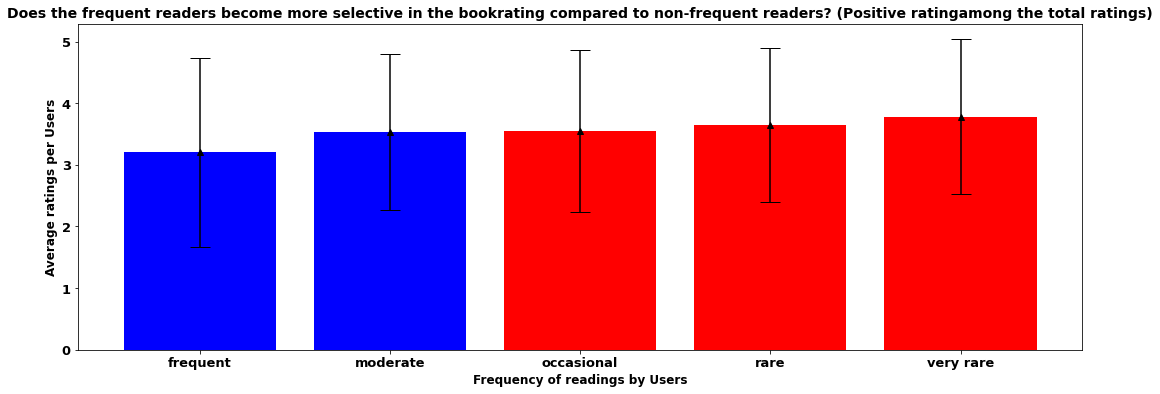

In [ ]:
## Add confidence intervals (or error bars)
## Make it in ascending orders

plt.figure(figsize=(18, 6))
plt.bar(result.loc[result.frequency.isin(["moderate", "frequent"])].frequency, result.loc[result.frequency.isin(["moderate", "frequent"])]['mean'], color="blue")
plt.bar(result.loc[result.frequency.isin(["very rare", "rare", "occasional"])].frequency, result.loc[result.frequency.isin(["very rare", "rare", "occasional"])]['mean'], color="red")
#plt.bar(result.frequency, result['mean'], color="blue")
plt.errorbar(result.frequency, result['mean'], result['std'], linestyle='None', marker='^', fmt='o', color='black', capsize=10)
plt.xlabel("Frequency of readings by Users", fontweight="bold", fontsize=12)
plt.ylabel("Average ratings per Users", fontweight="bold", fontsize=12)
plt.xticks(fontweight="bold", fontsize=13)
plt.yticks(fontweight="bold", fontsize=13)
plt.title("Does the frequent readers become more selective in the bookrating compared to non-frequent readers? (Positive ratingamong the total ratings)", fontweight="bold", fontsize=14)
plt.show()